In [1]:
#!pip install nltk
#!pip install emoji
#!pip install umap
#!pip install plotly


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string

import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


import os

# Création d'un répertoire local au cas où les chemins par défaut posent problème
nltk_data_dir = os.path.join(os.getcwd(), "nltk_data")
os.makedirs(nltk_data_dir, exist_ok=True)

# Ajout manuel au chemin
nltk.data.path.append(nltk_data_dir)

# Téléchargements des ressources nécessaires dans le bon répertoire
nltk.download("punkt", download_dir=nltk_data_dir)
nltk.download("stopwords", download_dir=nltk_data_dir)
nltk.download("wordnet", download_dir=nltk_data_dir)



[nltk_data] Downloading package punkt to /home/daniel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/daniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/daniel/Bureau/HAI817I -
[nltk_data]     Machine Learning/Machine_learning/Projet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/daniel/Bureau/HAI817I - Machine
[nltk_data]     Learning/Machine_learning/Projet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/daniel/Bureau/HAI817I
[nltk_data]     - Machine
[nltk_data]     Learning/Machine_learning/Projet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
df=pd.read_csv('scitweets_export.tsv', sep='\t') 
display (df.head())
print("Nombre total de lignes :", len(df))

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign that my recent treadmilling is working,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience explain the dangers of Transvaginal Douching with Fluoride or other toxins such as Dioxin? #PDX,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch. Gotta stop doing this shit.,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with bipolar disorder http://t.co/XGUfUDoLJB,1,1.0,0.0,0.0


Nombre total de lignes : 1140


In [3]:
#-------------------------------
#----Analyse du jeu de données – partie scientifique uniquement--------
#------------------------------

Nombre de lignes scientifiques : 375
CLAIM et REF uniquement (sans context) : 0
CLAIM et REF (avec context) : 124
CLAIM ou REF (avec context) : 342
CLAIM ou REF (sans context) : 263
CONTEXT uniquement (sans claim ou ref) : 33
CONTEXT (avec claim ou ref)  : 251


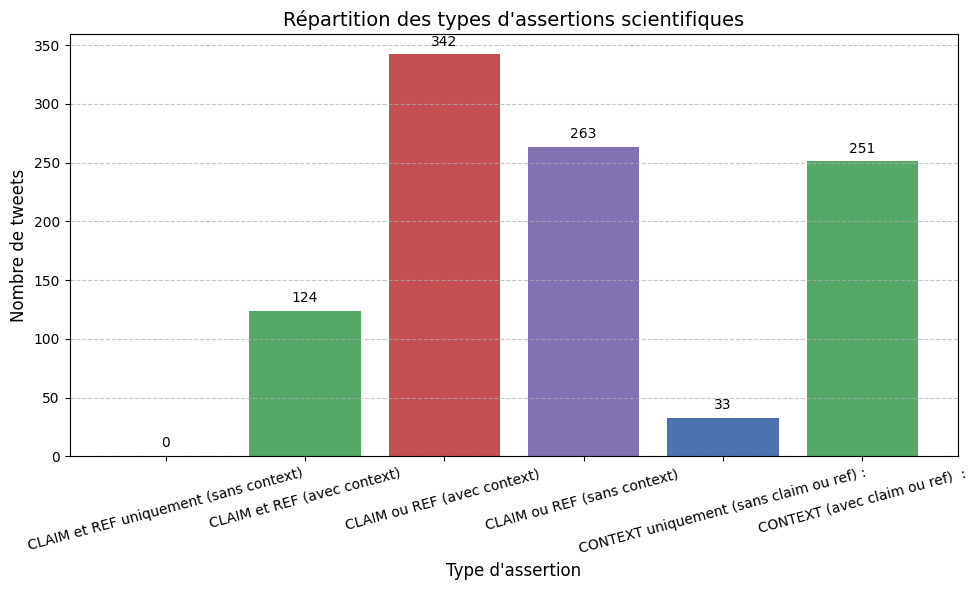

In [45]:
# 3. Filtrer les lignes scientifiques
df_sci = df[df["science_related"] == 1]
print("Nombre de lignes scientifiques :", len(df_sci))


# Classe CONTEXT (au moins)
df_context = df_sci[
    (df_sci["scientific_context"] == 1.0)
]

# Classe CONTEXT (uniquement)
df_context_unic = df_sci[
    (df_sci["scientific_context"] == 1.0) & (df_sci["scientific_claim"] == 0.0) & (df_sci["scientific_reference"] == 0.0)
]

# Classe CLAIM/REF (uniquement)
df_claim_ref_unic = df_sci[
    ((df_sci["scientific_claim"] == 1.0) & (df_sci["scientific_reference"] == 1.0)
    & (df_sci["scientific_context"] == 0.0))
]

# Classe CLAIM/REF (au moins)
df_claim_ref = df_sci[
    ((df_sci["scientific_claim"] == 1.0) & (df_sci["scientific_reference"] == 1.0))
]

# Classe CLAIM/REF (au plus)
df_claim_ou_ref = df_sci[
    ((df_sci["scientific_claim"] == 1.0) | (df_sci["scientific_reference"] == 1.0))
]

# Classe CLAIM/REF (au plus, sans context)
df_claim_ou_ref_unic = df_sci[
    ((df_sci["scientific_claim"] == 1.0) | (df_sci["scientific_reference"] == 1.0)
    & (df_sci["scientific_context"] == 0.0))
]


# 4. Vérification du déséquilibre initial
print("CLAIM et REF uniquement (sans context) :", len(df_claim_ref_unic))
print("CLAIM et REF (avec context) :", len(df_claim_ref))
print("CLAIM ou REF (avec context) :", len(df_claim_ou_ref))
print("CLAIM ou REF (sans context) :", len(df_claim_ou_ref_unic))
print("CONTEXT uniquement (sans claim ou ref) :", len(df_context_unic))
print("CONTEXT (avec claim ou ref)  :", len(df_context))


# 4. Création du dictionnaire de comptage
counts = {
    "CLAIM et REF uniquement (sans context)": len(df_claim_ref_unic),
    "CLAIM et REF (avec context)" :  len(df_claim_ref),
    "CLAIM ou REF (avec context) " :  len(df_claim_ou_ref),
    "CLAIM ou REF (sans context) " : len(df_claim_ou_ref_unic),
    "CONTEXT uniquement (sans claim ou ref) :" : len(df_context_unic),
    "CONTEXT (avec claim ou ref)  :" : len(df_context)
}


# 5. Création du DataFrame pour affichage
df_counts = pd.DataFrame(list(counts.items()), columns=["Catégorie", "Nombre"])

# 6. Affichage graphique
plt.figure(figsize=(10,6))
bars = plt.bar(df_counts["Catégorie"], df_counts["Nombre"], color=["#4C72B0", "#55A868", "#C44E52", "#8172B3"])
plt.title("Répartition des types d'assertions scientifiques", fontsize=14)
plt.xlabel("Type d'assertion", fontsize=12)
plt.ylabel("Nombre de tweets", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 7. Afficher les valeurs sur les barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Comment classer ?

On peut pas interpréter la deuxième tache comme CLAIM et REF vs CONTEXT car on n'a pas CLAIM et REF uniquement.
On va faire CLAIM ou REF (avec context) vs CONTEXT uniquement

In [5]:
#----------------------------------------------
#-----------------Reequilibrage de donnees -----------------------------
#----------------------------------------------

In [37]:
df_balanced=pd.read_csv('scitweets_export_final_v3.tsv', sep='\t') #contient les 2 classe equilibrer 251+251=502
display (df_balanced.head())
print("Nombre total de lignes :", len(df_balanced))

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0.0,316669998137483264,Knees are a bit sore. i guess that's a sign that my recent treadmilling is working,0,0.0,0.0,0.0
1,1.0,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2.0,322030931022065664,Can any Gynecologist with Cancer Experience explain the dangers of Transvaginal Douching with Fluoride or other toxins such as Dioxin? #PDX,1,1.0,0.0,0.0
3,3.0,322694830620807168,Couch-lock highs lead to sleeping in the couch. Gotta stop doing this shit.,1,1.0,0.0,0.0
4,4.0,328524426658328576,Does daily routine help prevent problems with bipolar disorder http://t.co/XGUfUDoLJB,1,1.0,0.0,0.0


Nombre total de lignes : 1267


In [38]:
# 3. Filtrer les lignes scientifiques
df_sci = df_balanced[df_balanced["science_related"] == 1]
print("Nombre de lignes scientifiques :", len(df_sci))


Nombre de lignes scientifiques : 502


In [41]:
from sklearn.utils import resample

# Classe CONTEXT (au moins)
df_context = df_sci[
    (df_sci["scientific_context"] == 1.0)
]

# Classe CONTEXT (uniquement)
df_context_unic = df_sci[
    (df_sci["scientific_context"] == 1.0) & (df_sci["scientific_claim"] == 0.0) & (df_sci["scientific_reference"] == 0.0)
]

# Classe CLAIM/REF (uniquement)
df_claim_ref_unic = df_sci[
    ((df_sci["scientific_claim"] == 1.0) & (df_sci["scientific_reference"] == 1.0)
    & (df_sci["scientific_context"] == 0.0))
]

# Classe CLAIM/REF (au moins)
df_claim_ref = df_sci[
    ((df_sci["scientific_claim"] == 1.0) & (df_sci["scientific_reference"] == 1.0))
]

# Classe CLAIM/REF (au plus)
df_claim_ou_ref = df_sci[
    ((df_sci["scientific_claim"] == 1.0) | (df_sci["scientific_reference"] == 1.0))
]

# Classe CLAIM/REF (au plus, sans context)
df_claim_ou_ref_unic = df_sci[
    ((df_sci["scientific_claim"] == 1.0) | (df_sci["scientific_reference"] == 1.0)
    & (df_sci["scientific_context"] == 0.0))
]


# 4. Vérification du déséquilibre initial
print("Apres équilibrage :")
print("CLAIM et REF uniquement (sans context) :", len(df_claim_ref_unic))
print("CLAIM et REF (avec context) :", len(df_claim_ref))
print("CLAIM ou REF (avec context) :", len(df_claim_ou_ref))
print("CLAIM ou REF (sans context) :", len(df_claim_ou_ref_unic))
print("CONTEXT uniquement (sans claim ou ref) :", len(df_context_unic))
print("CONTEXT (avec claim ou ref)  :", len(df_context))


Apres équilibrage :
CLAIM et REF uniquement (sans context) : 127
CLAIM et REF (avec context) : 251
CLAIM ou REF (avec context) : 469
CLAIM ou REF (sans context) : 390
CONTEXT uniquement (sans claim ou ref) : 33
CONTEXT (avec claim ou ref)  : 251


In [ ]:
# Formatage des données et création du label final :
# 1 si claim ET reference, 0 si au moins context (même s'il y a claim et/ou ref)
df_sci["label"] = df_sci.apply(
    lambda row: 0 if row["scientific_context"] == 1.0 else (
        1 if (row["scientific_claim"] == 1.0 and row["scientific_reference"] == 1.0) else 1
    ),
    axis=1
)


# Vérification finale
print("\nAprès équilibrage :")
print(df_sci["label"].value_counts())

print("CLAIM/REF :", len(df_claim_ref))
print("CONTEXT (upsampled) :", len(df_context))
print("Total lignes :", len(df_sci))

In [ ]:
# Label = 1 si CLAIM ou REF
df_sci['label'] = ((df_sci['scientific_claim'] == 1.0) | (df_sci['scientific_reference'] == 1.0)).astype(int)

# Tweets à garder :
# - tous les CLAIM ou REF (même s’ils ont CONTEXT)
# - uniquement les CONTEXT "purs" pour la classe 0

df_claim_ref = df_sci[df_sci['label'] == 1]
df_context_only = df_sci[
    (df_sci['scientific_context'] == 1.0) &
    (df_sci['scientific_claim'] == 0.0) &
    (df_sci['scientific_reference'] == 0.0)
]

In [9]:
# a partir de maintenant on travaille avec df_sci 

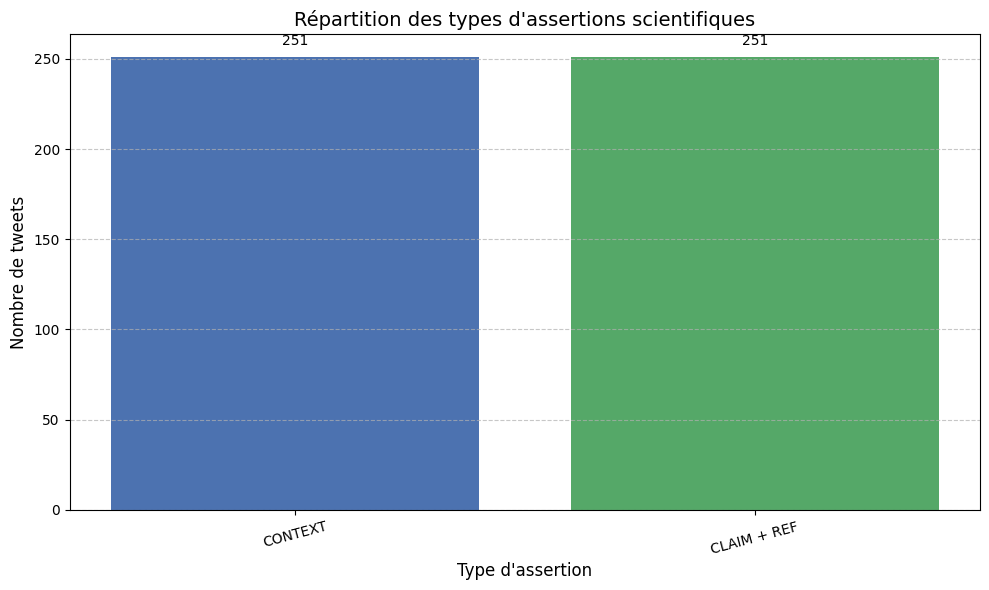

In [10]:
# 1. Créer un DataFrame de comptage personnalisé depuis df_balanced
label_map = {0: "CLAIM + REF", 1: "CONTEXT"}
df_counts = df_sci["label"].map(label_map).value_counts().reset_index()
df_counts.columns = ["Catégorie", "Nombre"]
'''
# 2. Affichage avec seaborn
sb.set_style("whitegrid")
plt.figure(figsize=(8, 6))
plot = sb.barplot(data=df_counts, x="Catégorie", y="Nombre", palette='pastel')
plt.title("Répartition des classes après équilibrage", fontsize=14)
plt.xlabel("Classe", fontsize=12)
plt.ylabel("Nombre d'occurrences", fontsize=12)

# 3. Affichage des valeurs au-dessus des barres
for p in plot.patches:
    plot.annotate(format(p.get_height(), '.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
'''

plt.figure(figsize=(10,6))
bars = plt.bar(df_counts["Catégorie"], df_counts["Nombre"], color=["#4C72B0", "#55A868", "#C44E52", "#8172B3"])
plt.title("Répartition des types d'assertions scientifiques", fontsize=14)
plt.xlabel("Type d'assertion", fontsize=12)
plt.ylabel("Nombre de tweets", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 7. Afficher les valeurs sur les barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [11]:
#-------------------------------
#----Nettoyage + normalisation du texte--------
#------------------------------

In [32]:
import re
import emoji

# 1. Fonction pour convertir les emojis en texte
def convert_emojis(text):
    return emoji.demojize(text)  # Exemple : 😊 devient :smiling_face_with_smiling_eyes:

# Appliquer la conversion sur le texte
df_sci['tweet_text'] = df_sci['text'].apply(convert_emojis)

# 2. Détection des éléments textuels :

# Détection d’URL
df_sci['has_url'] = df_sci['text'].str.contains(r'http[s]?://', regex=True)

# Détection de mentions (@username)
df_sci['has_mention'] = df_sci['text'].str.contains(r'@\w+', regex=True)

# Détection de hashtags (#mot)
df_sci['has_hashtag'] = df_sci['text'].str.contains(r'#\w+', regex=True)

# Détection d'emojis (format texte après demojize)
df_sci['has_emoji'] = df_sci['tweet_text'].str.contains(r':[^:\s]+:', regex=True)

# 3. Fonction pour compter par catégorie et par classe (label 0 ou 1)
def count_by_category(col):
    return df_sci.groupby('label')[col].sum()

# 4. Affichage des résultats :

print("- Tweets avec URL :")
display(count_by_category('has_url'))

print("- Tweets avec Mention :")
display(count_by_category('has_mention'))

print("- Tweets avec Hashtag :")
display(count_by_category('has_hashtag'))

print("- Tweets avec Emoji :")
display(count_by_category('has_emoji'))


- Tweets avec URL :


label
0    236
1    194
Name: has_url, dtype: int64

- Tweets avec Mention :


label
0    73
1    23
Name: has_mention, dtype: int64

- Tweets avec Hashtag :


label
0    84
1    39
Name: has_hashtag, dtype: int64

- Tweets avec Emoji :


label
0    2
1    4
Name: has_emoji, dtype: int64

In [33]:
df_sci.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502 entries, 2 to 1266
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  502 non-null    object 
 1   scientific_claim      502 non-null    float64
 2   scientific_reference  502 non-null    float64
 3   scientific_context    502 non-null    float64
 4   label                 502 non-null    int64  
 5   tweet_text            502 non-null    object 
 6   has_url               502 non-null    bool   
 7   has_mention           502 non-null    bool   
 8   has_hashtag           502 non-null    bool   
 9   has_emoji             502 non-null    bool   
dtypes: bool(4), float64(3), int64(1), object(2)
memory usage: 29.4+ KB


In [17]:
df_sci.drop(columns=['has_emoji','tweet_id','text','science_related'], inplace=True)

df_sci.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502 entries, 2 to 1266
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tweet_id              502 non-null    int64  
 1   text                  502 non-null    object 
 2   science_related       502 non-null    int64  
 3   scientific_claim      502 non-null    float64
 4   scientific_reference  502 non-null    float64
 5   scientific_context    502 non-null    float64
 6   label                 502 non-null    int64  
 7   tweet_text            502 non-null    object 
 8   has_url               502 non-null    bool   
 9   has_mention           502 non-null    bool   
 10  has_hashtag           502 non-null    bool   
dtypes: bool(3), float64(3), int64(3), object(2)
memory usage: 36.8+ KB


In [22]:
df_sci.drop(columns=['science_related'], inplace=True)


display(df_sci.head())

display((df_sci['text'] == df_sci['tweet_text']).all())


,text,scientific_claim,scientific_reference,scientific_context,label,tweet_text,has_url,has_mention,has_hashtag
2,Can any Gynecologist with Cancer Experience ex...,1.0,0.0,0.0,1,Can any Gynecologist with Cancer Experience ex...,False,False,True
3,Couch-lock highs lead to sleeping in the couch...,1.0,0.0,0.0,1,Couch-lock highs lead to sleeping in the couch...,False,False,False
4,Does daily routine help prevent problems with ...,1.0,0.0,0.0,1,Does daily routine help prevent problems with ...,True,False,False
6,“Traffic Jam” In Brain’s Neurons Could Be Caus...,1.0,1.0,1.0,0,“Traffic Jam” In Brain’s Neurons Could Be Caus...,True,False,False
7,Can playing more games improve lives and save ...,1.0,0.0,0.0,1,Can playing more games improve lives and save ...,True,True,True


np.False_

In [31]:
# Affichage
print(f"tweets text uniquement : {len(df_sci)}")
# Supprime la limite de longueur d'affichage des colonnes de texte
pd.set_option('display.max_colwidth', None)

display(df_sci[["text", "tweet_text"]])

display((df_sci['text'] == df_sci['tweet_text']).all())

diffs = df_sci[df_sci['text'] != df_sci['tweet_text']]
print(f"Nombre de différences : {len(diffs)}")
display(diffs[['text', 'tweet_text']])



tweets text uniquement : 502


,text,tweet_text
2,Can any Gynecologist with Cancer Experience explain the dangers of Transvaginal Douching with Fluoride or other toxins such as Dioxin? #PDX,Can any Gynecologist with Cancer Experience explain the dangers of Transvaginal Douching with Fluoride or other toxins such as Dioxin? #PDX
3,Couch-lock highs lead to sleeping in the couch. Gotta stop doing this shit.,Couch-lock highs lead to sleeping in the couch. Gotta stop doing this shit.
4,Does daily routine help prevent problems with bipolar disorder http://t.co/XGUfUDoLJB,Does daily routine help prevent problems with bipolar disorder http://t.co/XGUfUDoLJB
6,“Traffic Jam” In Brain’s Neurons Could Be Cause Of Statin-Related Cognitive Decline http://t.co/kQ3XPdePKX,“Traffic Jam” In Brain’s Neurons Could Be Cause Of Statin-Related Cognitive Decline http://t.co/kQ3XPdePKX
7,Can playing more games improve lives and save the world? by @chris_pelle via @PostArcade http://t.co/uEtVu099Ad #CDA30,Can playing more games improve lives and save the world? by @chris_pelle via @PostArcade http://t.co/uEtVu099Ad #CDA30
...,...,...
1262,Clinical trials confirm monoclonal antibodies effective against RSV. https://t.co/rsvtherapy,Clinical trials confirm monoclonal antibodies effective against RSV. https://t.co/rsvtherapy
1263,Machine learning system forecasts epileptic seizures 90 minutes in advance. https://t.co/epilepsyai,Machine learning system forecasts epileptic seizures 90 minutes in advance. https://t.co/epilepsyai
1264,Cryo-EM analysis uncovers structural insights into Alzheimer’s plaques. https://t.co/cryoplaque,Cryo-EM analysis uncovers structural insights into Alzheimer’s plaques. https://t.co/cryoplaque
1265,Ecological data show that mangrove restoration improves coastal resilience. https://t.co/mangrovecoast,Ecological data show that mangrove restoration improves coastal resilience. https://t.co/mangrovecoast


np.False_

Nombre de différences : 6


,text,tweet_text
141,🇺🇸 CBS: Census Data Show U.S. Doesn't Have Shortage of STEM Workers http://t.co/bhPpXhGcYI #WIUNION,:United_States: CBS: Census Data Show U.S. Doesn't Have Shortage of STEM Workers http://t.co/bhPpXhGcYI #WIUNION
364,"Hard work NEVER fails, start working, stop complaining. If you work for it, you'll appreciate it! 💯","Hard work NEVER fails, start working, stop complaining. If you work for it, you'll appreciate it! :hundred_points:"
797,Coffee Drinking Associated With Lower Risk of Stroke ➡ https://t.co/UziyhDa6WE https://t.co/8qHVzTjAHV,Coffee Drinking Associated With Lower Risk of Stroke :right_arrow: https://t.co/UziyhDa6WE https://t.co/8qHVzTjAHV
820,Nobody wants you till they think you’re in a relationship. Ain’t that some reverse psychology shit for you 😂,Nobody wants you till they think you’re in a relationship. Ain’t that some reverse psychology shit for you :face_with_tears_of_joy:
1026,"Did you know eye exercises & vision therapy can help with digital eye strain & certain eye conditions? Eye exercises will strengthen weak eye muscles, improve blood circulation & muscle tone. Try these eye exercise for a better & stronger vision 👁👁💙✨ #CentralAmericanTwitter https://t.co/KKrwUFJRvG","Did you know eye exercises & vision therapy can help with digital eye strain & certain eye conditions? Eye exercises will strengthen weak eye muscles, improve blood circulation & muscle tone. Try these eye exercise for a better & stronger vision :eye::eye::blue_heart::sparkles: #CentralAmericanTwitter https://t.co/KKrwUFJRvG"
1113,*Researches how to use Twitter as a scientist 🙂 Ten simple rules for getting started on Twitter as a scientist https://t.co/3bfLAacQgt #AcademicTwitter #ScienceTwitter #howto,*Researches how to use Twitter as a scientist :slightly_smiling_face: Ten simple rules for getting started on Twitter as a scientist https://t.co/3bfLAacQgt #AcademicTwitter #ScienceTwitter #howto


In [13]:
#------------------------------------------------------------
#--------matrice tf-idf avce les données brut---------------
#-------------------------------------------------------------

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# Étape 1 : Nettoyage minimal (éviter les NaN sur le texte)
df_sci.dropna(subset=['tweet_text'], inplace=True)

# Étape 2 : Sélection du texte brut et du label
X_text = df_sci['tweet_text']  
y = df_sci['label']          

# Étape 3 : Création de la matrice TF-IDF à partir du texte brut
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)

# ✅ Étape 4 : Création de la matrice des features binaires supplémentaires
# Convertir les booléens en int (0 ou 1) si nécessaire
extra_features = df_sci[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
X_extra = scipy.sparse.csr_matrix(extra_features.values)

# ✅ Étape 5 : Concaténer TF-IDF + features supplémentaires
X_final = scipy.sparse.hstack([X_tfidf, X_extra])

# ✅ Étape 6 : Affichage des tailles
print("📐 Taille de la matrice TF-IDF :", X_tfidf.shape)
print("📐 Taille des features supplémentaires :", X_extra.shape)
print("📐 Taille finale (TF-IDF + extra features) :", X_final.shape)


📐 Taille de la matrice TF-IDF : (502, 3842)
📐 Taille des features supplémentaires : (502, 4)
📐 Taille finale (TF-IDF + extra features) : (502, 3846)


In [15]:
import re
import pandas as pd

# ✅ Convertir la matrice TF-IDF en DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# ✅ Fonction de catégorisation des tokens
def get_token_category(token):
    if token.isdigit():
        return 'numeric'
    if re.match(r'^\d+(am|pm|s|h|min|sec|hour|years)?$', token.lower()):
        return 'timestamp'
    if re.match(r'^[a-zA-Z]+$', token):
        return 'valid'
    return 'other'

# ✅ Classer chaque token
token_categories = {token: get_token_category(token) for token in tfidf_df.columns}

# ✅ Regrouper par type
valid_tokens = [token for token, cat in token_categories.items() if cat == 'valid']
numeric_tokens = [token for token, cat in token_categories.items() if cat == 'numeric']
timestamp_tokens = [token for token, cat in token_categories.items() if cat == 'timestamp']

# ✅ Colonnes agrégées
tfidf_df['numeric'] = tfidf_df[numeric_tokens].sum(axis=1) if numeric_tokens else 0
tfidf_df['timestamp'] = tfidf_df[timestamp_tokens].sum(axis=1) if timestamp_tokens else 0

# ✅ Garder uniquement les tokens valides + colonnes synthétiques
tfidf_cleaned = tfidf_df[valid_tokens + ['numeric', 'timestamp']]

X_cleaned = scipy.sparse.csr_matrix(tfidf_cleaned.values)

X_final_clean = scipy.sparse.hstack([X_final, X_cleaned])


# ✅ Aperçu
print("📄 Aperçu de la matrice TF-IDF nettoyée (texte brut) :")
display(tfidf_cleaned.head())
print("📐 Taille finale :", tfidf_cleaned.shape)


📄 Aperçu de la matrice TF-IDF nettoyée (texte brut) :


,abilities,ability,able,abnormal,abortion,abortions,about,absolute,abstract,abuse,...,zachary,zheng,zhengli,zhu,zika,zjghyzrngd,zoonotic,zoonoticmodel,numeric,timestamp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


📐 Taille finale : (502, 3364)


In [147]:
#------------------------------------------------------------
#--------Separation des donnees pour le train/test---------------
#-------------------------------------------------------------

,Accuracy,Precision,Recall,F1 Score
Naïve Bayes,0.731 ± 0.031,0.843,0.578,0.680
Logistic Regression,0.731 ± 0.051,0.701,0.825,0.755
Multinomial NB,0.731 ± 0.031,0.843,0.578,0.680
Random Forest,0.785 ± 0.036,0.799,0.761,0.779
SVM,0.699 ± 0.048,0.655,0.853,0.740
SVM linear,0.757 ± 0.033,0.750,0.777,0.761
KNN,0.769 ± 0.027,0.760,0.793,0.774
AdaBoost,0.753 ± 0.030,0.761,0.741,0.749
Gradient Boosting,0.779 ± 0.028,0.796,0.753,0.772
XGBoost,0.767 ± 0.039,0.782,0.745,0.762


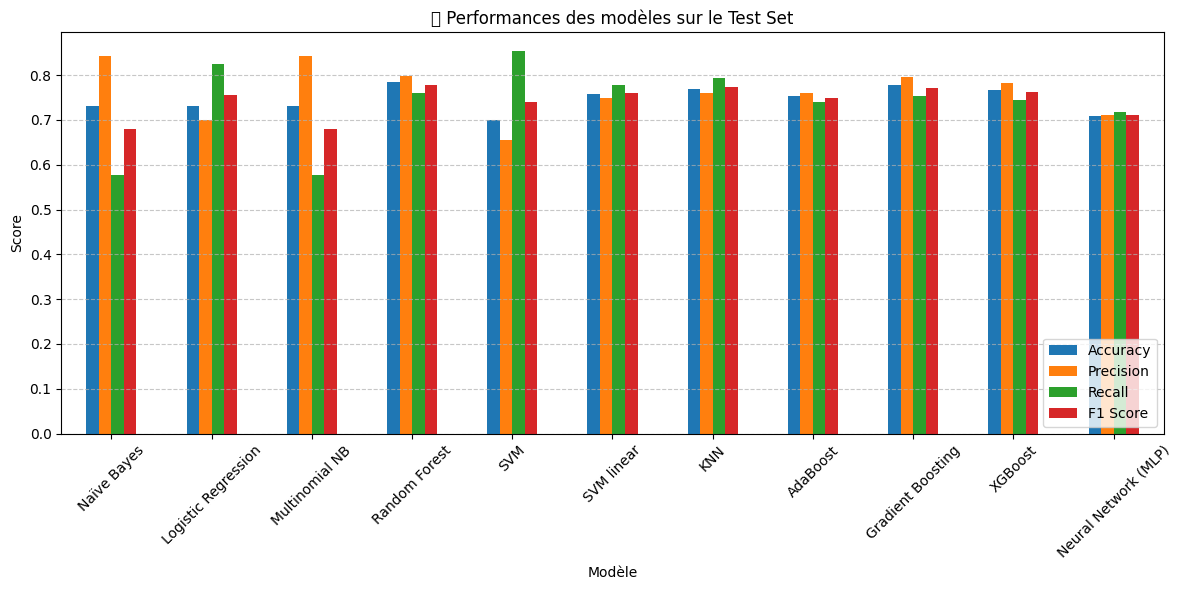

In [148]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# ✅ Dictionnaire des modèles
models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Multinomial NB": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "SVM linear": LinearSVC(),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Neural Network (MLP)": MLPClassifier(max_iter=300)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = {}

X = X_final

# Boucle sur chaque modèle
for model_name, model in models.items():
    acc_list, prec_list, rec_list, f1_list = [], [], [], []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            acc_list.append(accuracy_score(y_test, y_pred))
            prec_list.append(precision_score(y_test, y_pred, zero_division=0))
            rec_list.append(recall_score(y_test, y_pred, zero_division=0))
            f1_list.append(f1_score(y_test, y_pred, zero_division=0))
        
        except Exception as e:
            print(f"❌ Erreur pour {model_name} : {e}")
            acc_list.append(np.nan)
            prec_list.append(np.nan)
            rec_list.append(np.nan)
            f1_list.append(np.nan)
    
    # Résumé des scores pour le modèle courant
    scores[model_name] = {
        "Accuracy": f"{np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}",
        "Precision": f"{np.mean(prec_list):.3f}",
        "Recall": f"{np.mean(rec_list):.3f}",
        "F1 Score": f"{np.mean(f1_list):.3f}",
    }

df_scores = pd.DataFrame(scores).T

display(df_scores)

# On extrait uniquement les moyennes numériques (pas l'écart-type)
plot_df = df_scores[["Accuracy", "Precision", "Recall", "F1 Score"]].copy()
plot_df["Accuracy"] = plot_df["Accuracy"].str.extract(r"([\d\.]+)").astype(float)
plot_df[["Precision", "Recall", "F1 Score"]] = plot_df[["Precision", "Recall", "F1 Score"]].astype(float)

plot_df.plot(kind='bar', figsize=(12, 6))
plt.title("📊 Performances des modèles sur le Test Set")
plt.xlabel("Modèle")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


,Accuracy,Precision,Recall,F1 Score
Naïve Bayes,0.727 ± 0.034,0.825,0.582,0.678
Logistic Regression,0.741 ± 0.042,0.716,0.805,0.757
Multinomial NB,0.727 ± 0.034,0.825,0.582,0.678
Random Forest,0.783 ± 0.029,0.812,0.737,0.772
SVM,0.719 ± 0.040,0.689,0.809,0.742
SVM linear,0.753 ± 0.026,0.747,0.765,0.754
KNN,0.721 ± 0.056,0.856,0.537,0.646
AdaBoost,0.753 ± 0.030,0.761,0.741,0.749
Gradient Boosting,0.785 ± 0.034,0.804,0.757,0.778
XGBoost,0.763 ± 0.046,0.769,0.757,0.762


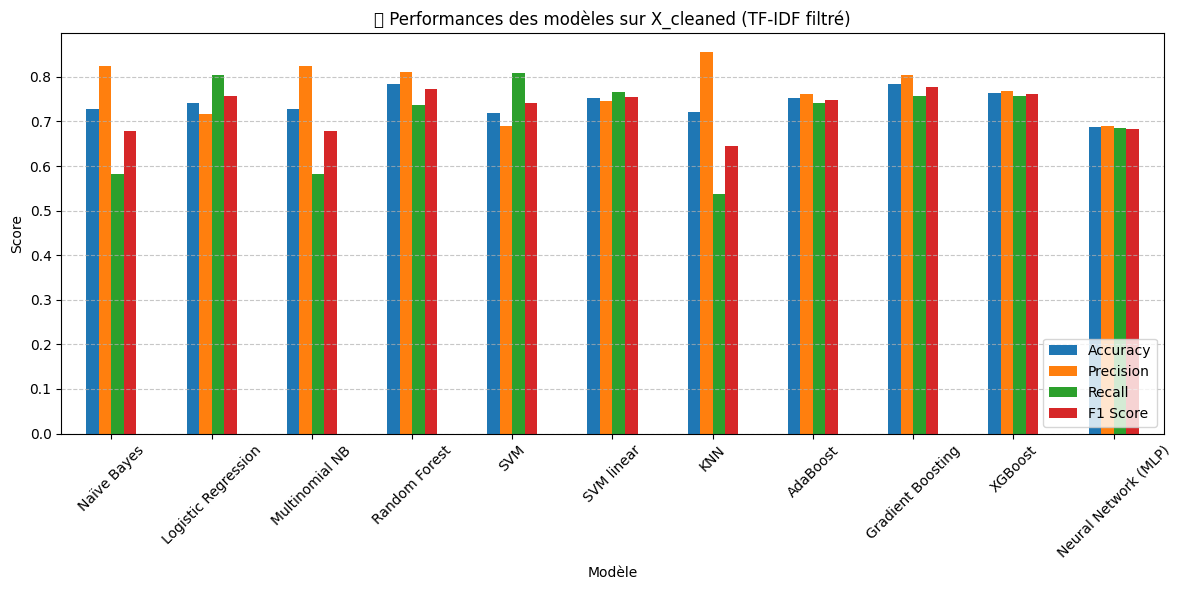

In [150]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

# 📦 Import des modèles
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

# ✅ Dictionnaire des modèles
models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Multinomial NB": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "SVM linear": LinearSVC(),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Neural Network (MLP)": MLPClassifier(max_iter=300)
}

X = X_final_clean

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = {}

# ✅ Boucle sur chaque modèle
for model_name, model in models.items():
    acc_list, prec_list, rec_list, f1_list = [], [], [], []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            acc_list.append(accuracy_score(y_test, y_pred))
            prec_list.append(precision_score(y_test, y_pred, zero_division=0))
            rec_list.append(recall_score(y_test, y_pred, zero_division=0))
            f1_list.append(f1_score(y_test, y_pred, zero_division=0))
        
        except Exception as e:
            print(f"❌ Erreur pour {model_name} : {e}")
            acc_list.append(np.nan)
            prec_list.append(np.nan)
            rec_list.append(np.nan)
            f1_list.append(np.nan)
    
    scores[model_name] = {
        "Accuracy": f"{np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}",
        "Precision": f"{np.mean(prec_list):.3f}",
        "Recall": f"{np.mean(rec_list):.3f}",
        "F1 Score": f"{np.mean(f1_list):.3f}",
    }

# ✅ Résumé global
df_scores = pd.DataFrame(scores).T

# 📋 Affichage du tableau
display(df_scores)

# ✅ Visualisation (moyennes uniquement)
plot_df = df_scores[["Accuracy", "Precision", "Recall", "F1 Score"]].copy()
plot_df["Accuracy"] = plot_df["Accuracy"].str.extract(r"([\d\.]+)").astype(float)
plot_df[["Precision", "Recall", "F1 Score"]] = plot_df[["Precision", "Recall", "F1 Score"]].astype(float)

plot_df.plot(kind='bar', figsize=(12, 6))
plt.title("📊 Performances des modèles sur X_cleaned (TF-IDF filtré)")
plt.xlabel("Modèle")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [42]:
#------------------------------------------------------------
#--------a partir de la c'est avec pre-traitement---------------
#-------------------------------------------------------------

In [46]:
import re
import spacy
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# 🔹 Charger les modèles spaCy pour FR et EN
# nlp_fr = spacy.load("fr_core_news_sm")
# nlp_en = spacy.load("en_core_web_sm")

# 🔹 Fonction de nettoyage simple (lower, suppression URL, mentions, hashtags, ponctuation)
def clean_text_for_model(text):
    text = text.lower()
    text = re.sub(r"http\S+", "URL", text)
    text = re.sub(r"@\w+", "MENTION", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r":[^:\s]+:", "", text)
    return text
'''
# 🔹 Fonction de nettoyage + lemmatisation multilingue
 def clean_and_lemmatize_multilang(text):
    text = clean_text_for_model(text)  # Nettoyage simple d'abord

    try:
        lang = detect(text)
    except:
        lang = "en"  # fallback sécurité

    if lang == "fr":
        doc = nlp_fr(text)
    else:
        doc = nlp_en(text)

    lemmatized = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return lemmatized
'''
# ✅ Appliquer la fonction à ton vrai dataset
df_sci['text_clean'] = df_sci['tweet_text'].apply(clean_text_for_model)

# ✅ Aperçu rapide
print("Aperçu du texte nettoyé :")
display(df_sci[['tweet_text', 'text_clean']].head())


KeyError: 'tweet_text'

In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# ✅ Nettoyage des valeurs manquantes sur le texte nettoyé
df_sci.dropna(subset=['text_clean'], inplace=True)

# ✅ Texte et labels
X_text = df_sci['text_clean']
y = df_sci['label']

# ✅ TF-IDF vectorisation sur le texte nettoyé
print("⏳ Vectorisation TF-IDF en cours...")
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)
print("✅ TF-IDF vectorisé.")

# ✅ Ajouter les colonnes binaires (URL, mention, hashtag, emoji)
extra_features = df_sci[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
X_extra = scipy.sparse.csr_matrix(extra_features.values)

# ✅ Fusion TF-IDF + features supplémentaires
X_final = scipy.sparse.hstack([X_tfidf, X_extra])

# ✅ Affichage des tailles
print("📐 Taille de la matrice TF-IDF :", X_tfidf.shape)
print("📐 Taille des features supplémentaires :", X_extra.shape)
print("📐 Taille finale combinée :", X_final.shape)


⏳ Vectorisation TF-IDF en cours...
✅ TF-IDF vectorisé.
📐 Taille de la matrice TF-IDF : (502, 3170)
📐 Taille des features supplémentaires : (502, 4)
📐 Taille finale combinée : (502, 3174)


In [153]:
#------------------------------------------------------------------
#-------pre-traitement commplet------------------------
#----------------------------------------------------

In [157]:
import re
import pandas as pd
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer

# 🔹 Charger les stopwords français
stopwords_df = pd.read_csv("StopWordsFrench.csv", sep=',', index_col=0)
french_stopwords = stopwords_df.index.tolist()

# 🔹 Application nettoyage + lemmatisation sur df_balanced
print("⏳ Nettoyage (version 2)...")
df_sci['text_clean_2'] = df_sci['tweet_text'].apply(clean_text_for_model)
print("✅ Texte nettoyé (version 2).")

# 🔹 TF-IDF avancé (avec paramètres spécifiques)
vectorizer2 = TfidfVectorizer(
    # min_df=5,
    max_df=0.95,
    stop_words=french_stopwords,
    ngram_range=(1, 2),
    max_features=5000
)
X_tfidf2 = vectorizer2.fit_transform(df_sci['text_clean_2'])

# ➕ DataFrame version 2
tfidf_df2 = pd.DataFrame(X_tfidf2.toarray(), columns=vectorizer2.get_feature_names_out())

# 🔹 Filtrage des tokens : uniquement lettres (supprimer chiffres isolés)
def is_valid_token(token):
    if token.isdigit():
        return False
    return bool(re.match(r'^[a-zA-ZÀ-ÿ\-]+$', token))

valid_columns2 = [token for token in tfidf_df2.columns if is_valid_token(token)]
numeric_columns2 = [token for token in tfidf_df2.columns if token.isdigit()]

# 🔹 Colonnes synthétiques pour numériques
tfidf_df2['numeric'] = tfidf_df2[numeric_columns2].sum(axis=1) if numeric_columns2 else 0
tfidf_df2.drop(columns=numeric_columns2, inplace=True)

# 🔹 On ne garde que les colonnes valides + numeric
tfidf_filtered_df2 = tfidf_df2[valid_columns2 + ['numeric']]

# 🔹 Features binaires déjà détectées
extra_features2 = df_sci[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
X_extra2 = scipy.sparse.csr_matrix(extra_features2.values)

# 🔹 Fusion finale TF-IDF filtré + features binaires
X_final2 = scipy.sparse.hstack([scipy.sparse.csr_matrix(tfidf_filtered_df2.values), X_extra2])

# 🔹 Labels correspondants
y2 = df_sci['label']

# 🔹 Affichage des tailles finales
print("📐 Taille TF-IDF filtrée (v2) :", tfidf_filtered_df2.shape)
print("📐 Taille finale avec features binaires (v2) :", X_final2.shape)


⏳ Nettoyage (version 2)...
✅ Texte nettoyé (version 2).
📐 Taille TF-IDF filtrée (v2) : (502, 1884)
📐 Taille finale avec features binaires (v2) : (502, 1888)


,Accuracy,Precision,Recall,F1 Score
Naïve Bayes,0.729 ± 0.031,0.824,0.586,0.682
Logistic Regression,0.723 ± 0.044,0.693,0.817,0.748
Multinomial NB,0.729 ± 0.031,0.824,0.586,0.682
Random Forest,0.759 ± 0.048,0.772,0.741,0.755
SVM,0.707 ± 0.059,0.665,0.853,0.746
SVM Linear,0.749 ± 0.024,0.744,0.765,0.752
KNN,0.773 ± 0.031,0.769,0.781,0.773
AdaBoost,0.709 ± 0.038,0.689,0.769,0.725
Gradient Boosting,0.763 ± 0.043,0.759,0.773,0.764
XGBoost,0.767 ± 0.034,0.769,0.769,0.767


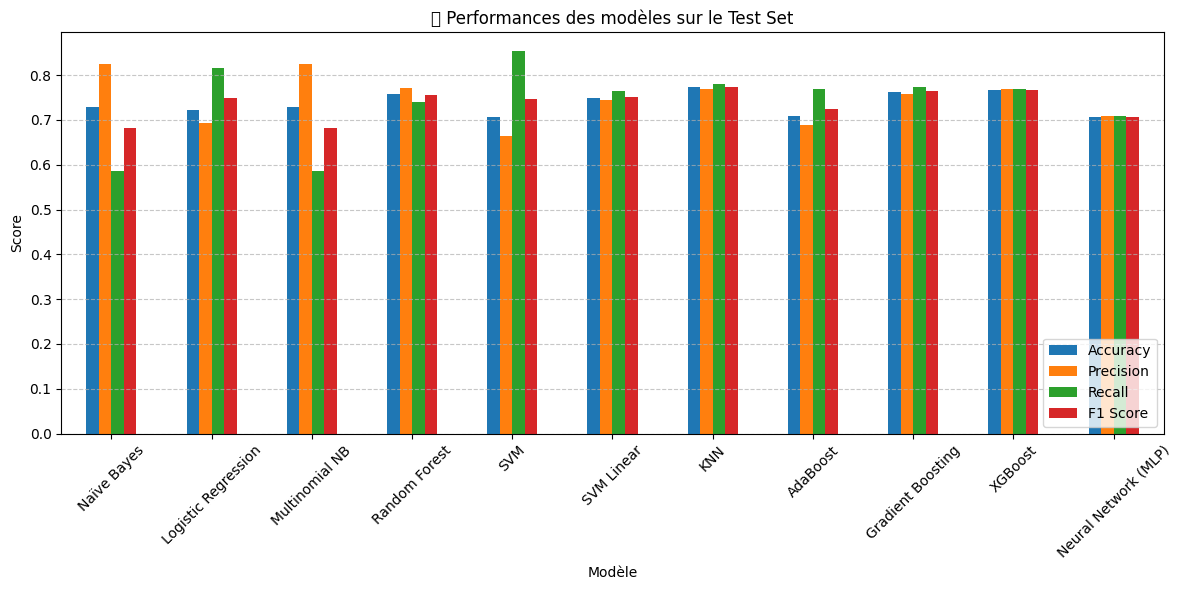

In [159]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

# ✅ Dictionnaire des modèles
models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Multinomial NB": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "SVM Linear": LinearSVC(),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Neural Network (MLP)": MLPClassifier(max_iter=300)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = {}

X = X_final

# Boucle sur chaque modèle
for model_name, model in models.items():
    acc_list, prec_list, rec_list, f1_list = [], [], [], []
    
    for train_idx, test_idx in skf.split(X, y2):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y2.iloc[train_idx], y2.iloc[test_idx]
        
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            
            acc_list.append(accuracy_score(y_test, y_pred))
            prec_list.append(precision_score(y_test, y_pred, zero_division=0))
            rec_list.append(recall_score(y_test, y_pred, zero_division=0))
            f1_list.append(f1_score(y_test, y_pred, zero_division=0))
        
        except Exception as e:
            print(f"❌ Erreur pour {model_name} : {e}")
            acc_list.append(np.nan)
            prec_list.append(np.nan)
            rec_list.append(np.nan)
            f1_list.append(np.nan)
    
    # Résumé des scores pour le modèle courant
    scores[model_name] = {
        "Accuracy": f"{np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}",
        "Precision": f"{np.mean(prec_list):.3f}",
        "Recall": f"{np.mean(rec_list):.3f}",
        "F1 Score": f"{np.mean(f1_list):.3f}",
    }

df_scores = pd.DataFrame(scores).T

display(df_scores)

# On extrait uniquement les moyennes numériques (pas l'écart-type)
plot_df = df_scores[["Accuracy", "Precision", "Recall", "F1 Score"]].copy()
plot_df["Accuracy"] = plot_df["Accuracy"].str.extract(r"([\d\.]+)").astype(float)
plot_df[["Precision", "Recall", "F1 Score"]] = plot_df[["Precision", "Recall", "F1 Score"]].astype(float)

plot_df.plot(kind='bar', figsize=(12, 6))
plt.title("📊 Performances des modèles sur le Test Set")
plt.xlabel("Modèle")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [83]:
#------------------------------------------------------------
#--------HYPERPARAMETRES---------------
#-------------------------------------------------------------

[I 2025-05-02 11:14:29,850] A new study created in memory with name: no-name-6bdd566e-5757-4574-9017-3c4990441aa4
[I 2025-05-02 11:14:29,861] Trial 0 finished with value: 0.7172871287128713 and parameters: {'alpha': 0.32160370147254075}. Best is trial 0 with value: 0.7172871287128713.
[I 2025-05-02 11:14:29,870] Trial 1 finished with value: 0.6774455445544556 and parameters: {'alpha': 0.07817213242397411}. Best is trial 0 with value: 0.7172871287128713.
[I 2025-05-02 11:14:29,879] Trial 2 finished with value: 0.7331287128712871 and parameters: {'alpha': 0.8785879067207961}. Best is trial 2 with value: 0.7331287128712871.
[I 2025-05-02 11:14:29,889] Trial 3 finished with value: 0.7171683168316833 and parameters: {'alpha': 0.7279385294269417}. Best is trial 2 with value: 0.7331287128712871.
[I 2025-05-02 11:14:29,898] Trial 4 finished with value: 0.7131881188118812 and parameters: {'alpha': 0.6014205161776175}. Best is trial 2 with value: 0.7331287128712871.
[I 2025-05-02 11:14:29,908] T

🔍 Optimisation de Naïve Bayes...


[I 2025-05-02 11:14:30,062] Trial 16 finished with value: 0.7231485148514851 and parameters: {'alpha': 0.8135281149785317}. Best is trial 2 with value: 0.7331287128712871.
[I 2025-05-02 11:14:30,074] Trial 17 finished with value: 0.7151683168316831 and parameters: {'alpha': 0.6500968337396882}. Best is trial 2 with value: 0.7331287128712871.
[I 2025-05-02 11:14:30,085] Trial 18 finished with value: 0.7331287128712871 and parameters: {'alpha': 0.8770276252280447}. Best is trial 2 with value: 0.7331287128712871.
[I 2025-05-02 11:14:30,096] Trial 19 finished with value: 0.7211485148514851 and parameters: {'alpha': 0.44722698140917116}. Best is trial 2 with value: 0.7331287128712871.
[I 2025-05-02 11:14:30,108] Trial 20 finished with value: 0.7131683168316831 and parameters: {'alpha': 0.6937463813639699}. Best is trial 2 with value: 0.7331287128712871.
[I 2025-05-02 11:14:30,120] Trial 21 finished with value: 0.733128712871287 and parameters: {'alpha': 0.8963111161070637}. Best is trial 2 

🔍 Optimisation de Logistic Regression...


[I 2025-05-02 11:14:33,215] Trial 4 finished with value: 0.7410693069306931 and parameters: {'C': 0.9203663184745154}. Best is trial 4 with value: 0.7410693069306931.
[I 2025-05-02 11:14:33,239] Trial 5 finished with value: 0.6714059405940593 and parameters: {'C': 0.001965946441900095}. Best is trial 4 with value: 0.7410693069306931.
[I 2025-05-02 11:14:33,282] Trial 6 finished with value: 0.6892871287128712 and parameters: {'C': 0.11166979370237239}. Best is trial 4 with value: 0.7410693069306931.
[I 2025-05-02 11:14:33,318] Trial 7 finished with value: 0.6714059405940593 and parameters: {'C': 0.006972179680450634}. Best is trial 4 with value: 0.7410693069306931.
[I 2025-05-02 11:14:33,355] Trial 8 finished with value: 0.6714059405940593 and parameters: {'C': 0.0020502134841985068}. Best is trial 4 with value: 0.7410693069306931.
[I 2025-05-02 11:14:33,378] Trial 9 finished with value: 0.6753861386138613 and parameters: {'C': 0.031569447095199266}. Best is trial 4 with value: 0.741069

🔍 Optimisation de Random Forest...


[I 2025-05-02 11:14:47,564] Trial 0 finished with value: 0.7589306930693069 and parameters: {'n_estimators': 197, 'max_depth': 7, 'min_samples_split': 6, 'max_features': 'log2'}. Best is trial 0 with value: 0.7589306930693069.
[I 2025-05-02 11:15:00,200] Trial 1 finished with value: 0.780970297029703 and parameters: {'n_estimators': 167, 'max_depth': 13, 'min_samples_split': 9, 'max_features': None}. Best is trial 1 with value: 0.780970297029703.
[I 2025-05-02 11:15:01,150] Trial 2 finished with value: 0.790970297029703 and parameters: {'n_estimators': 130, 'max_depth': 16, 'min_samples_split': 6, 'max_features': 'sqrt'}. Best is trial 2 with value: 0.790970297029703.
[I 2025-05-02 11:15:01,955] Trial 3 finished with value: 0.769009900990099 and parameters: {'n_estimators': 169, 'max_depth': 17, 'min_samples_split': 3, 'max_features': 'log2'}. Best is trial 2 with value: 0.790970297029703.
[I 2025-05-02 11:15:02,289] Trial 4 finished with value: 0.7492475247524751 and parameters: {'n_e

🔍 Optimisation de SVM...


[I 2025-05-02 11:22:11,696] Trial 0 finished with value: 0.7191683168316831 and parameters: {'kernel': 'sigmoid', 'C': 0.8600557447992999, 'gamma': 'scale'}. Best is trial 0 with value: 0.7191683168316831.
[I 2025-05-02 11:22:11,948] Trial 1 finished with value: 0.758970297029703 and parameters: {'kernel': 'linear', 'C': 0.8407986306433541, 'gamma': 'auto'}. Best is trial 1 with value: 0.758970297029703.
[I 2025-05-02 11:22:12,211] Trial 2 finished with value: 0.610019801980198 and parameters: {'kernel': 'sigmoid', 'C': 0.05592497686902213, 'gamma': 'auto'}. Best is trial 1 with value: 0.758970297029703.
[I 2025-05-02 11:22:12,474] Trial 3 finished with value: 0.610019801980198 and parameters: {'kernel': 'rbf', 'C': 0.6703073498556045, 'gamma': 'auto'}. Best is trial 1 with value: 0.758970297029703.
[I 2025-05-02 11:22:12,720] Trial 4 finished with value: 0.6812871287128713 and parameters: {'kernel': 'sigmoid', 'C': 0.27292280933664725, 'gamma': 'scale'}. Best is trial 1 with value: 0.

🔍 Optimisation de KNN...


[I 2025-05-02 11:23:12,763] Trial 12 finished with value: 0.7231881188118812 and parameters: {'n_neighbors': 5, 'weights': 'distance'}. Best is trial 10 with value: 0.7390297029702971.
[I 2025-05-02 11:23:12,782] Trial 13 finished with value: 0.7311287128712871 and parameters: {'n_neighbors': 3, 'weights': 'distance'}. Best is trial 10 with value: 0.7390297029702971.
[I 2025-05-02 11:23:12,800] Trial 14 finished with value: 0.746970297029703 and parameters: {'n_neighbors': 8, 'weights': 'distance'}. Best is trial 14 with value: 0.746970297029703.
[I 2025-05-02 11:23:12,819] Trial 15 finished with value: 0.746970297029703 and parameters: {'n_neighbors': 8, 'weights': 'distance'}. Best is trial 14 with value: 0.746970297029703.
[I 2025-05-02 11:23:12,837] Trial 16 finished with value: 0.746970297029703 and parameters: {'n_neighbors': 8, 'weights': 'distance'}. Best is trial 14 with value: 0.746970297029703.
[I 2025-05-02 11:23:12,855] Trial 17 finished with value: 0.7311287128712871 and 

🔍 Optimisation de AdaBoost...


[I 2025-05-02 11:23:19,781] Trial 0 finished with value: 0.7412079207920792 and parameters: {'n_estimators': 101, 'learning_rate': 0.7782693947218443}. Best is trial 0 with value: 0.7412079207920792.
[I 2025-05-02 11:23:22,652] Trial 1 finished with value: 0.7312673267326733 and parameters: {'n_estimators': 130, 'learning_rate': 0.5437528038640005}. Best is trial 0 with value: 0.7412079207920792.
[I 2025-05-02 11:23:25,227] Trial 2 finished with value: 0.7372475247524752 and parameters: {'n_estimators': 115, 'learning_rate': 0.48271581108623274}. Best is trial 0 with value: 0.7412079207920792.
[I 2025-05-02 11:23:29,644] Trial 3 finished with value: 0.7273069306930693 and parameters: {'n_estimators': 199, 'learning_rate': 0.3600285750557131}. Best is trial 0 with value: 0.7412079207920792.
[I 2025-05-02 11:23:32,325] Trial 4 finished with value: 0.7391485148514851 and parameters: {'n_estimators': 119, 'learning_rate': 0.6086702488451561}. Best is trial 0 with value: 0.7412079207920792.

🔍 Optimisation de Gradient Boosting...


[I 2025-05-02 11:39:35,918] Trial 0 finished with value: 0.7789108910891088 and parameters: {'n_estimators': 129, 'learning_rate': 0.08335631013110074, 'max_depth': 8, 'subsample': 0.7383349993493307}. Best is trial 0 with value: 0.7789108910891088.
[I 2025-05-02 11:39:37,281] Trial 1 finished with value: 0.757128712871287 and parameters: {'n_estimators': 62, 'learning_rate': 0.8147985620959053, 'max_depth': 2, 'subsample': 0.7566219040741976}. Best is trial 0 with value: 0.7789108910891088.
[I 2025-05-02 11:39:42,230] Trial 2 finished with value: 0.7770495049504951 and parameters: {'n_estimators': 93, 'learning_rate': 0.6378128649583603, 'max_depth': 8, 'subsample': 0.5222574324926719}. Best is trial 0 with value: 0.7789108910891088.
[I 2025-05-02 11:39:55,137] Trial 3 finished with value: 0.770930693069307 and parameters: {'n_estimators': 134, 'learning_rate': 0.1621747710689953, 'max_depth': 10, 'subsample': 0.7615372000310914}. Best is trial 0 with value: 0.7789108910891088.
[I 202

🔍 Optimisation de XGBoost...


[I 2025-05-02 11:57:00,088] Trial 0 finished with value: 0.760970297029703 and parameters: {'n_estimators': 53, 'learning_rate': 0.1678779494504626, 'max_depth': 8, 'subsample': 0.8365633701042376, 'colsample_bytree': 0.6518131761035167}. Best is trial 0 with value: 0.760970297029703.
[I 2025-05-02 11:57:00,604] Trial 1 finished with value: 0.751029702970297 and parameters: {'n_estimators': 64, 'learning_rate': 0.2506236049741574, 'max_depth': 9, 'subsample': 0.9214539992138553, 'colsample_bytree': 0.6575310550402553}. Best is trial 0 with value: 0.760970297029703.
[I 2025-05-02 11:57:01,454] Trial 2 finished with value: 0.740990099009901 and parameters: {'n_estimators': 190, 'learning_rate': 0.47236697065361866, 'max_depth': 6, 'subsample': 0.5589383529245339, 'colsample_bytree': 0.7085728618468379}. Best is trial 0 with value: 0.760970297029703.
[I 2025-05-02 11:57:01,774] Trial 3 finished with value: 0.752970297029703 and parameters: {'n_estimators': 50, 'learning_rate': 0.441425489

🔍 Optimisation de Neural Network (MLP)...


[I 2025-05-02 12:01:52,877] Trial 0 finished with value: 0.6674851485148515 and parameters: {'hidden_layer_sizes': 67, 'learning_rate_init': 0.09837858971328799, 'activation': 'tanh', 'alpha': 0.03946592684264777}. Best is trial 0 with value: 0.6674851485148515.
[I 2025-05-02 12:02:02,331] Trial 1 finished with value: 0.6358811881188119 and parameters: {'hidden_layer_sizes': 124, 'learning_rate_init': 0.005120107794987739, 'activation': 'relu', 'alpha': 0.08308857270083489}. Best is trial 0 with value: 0.6674851485148515.
[I 2025-05-02 12:02:10,766] Trial 2 finished with value: 0.6574455445544555 and parameters: {'hidden_layer_sizes': 154, 'learning_rate_init': 0.0759449906756261, 'activation': 'relu', 'alpha': 0.011331659321698499}. Best is trial 0 with value: 0.6674851485148515.
[I 2025-05-02 12:02:17,177] Trial 3 finished with value: 0.707069306930693 and parameters: {'hidden_layer_sizes': 81, 'learning_rate_init': 0.010561065859979929, 'activation': 'relu', 'alpha': 0.0345989728400

,Accuracy,Precision,Recall,F1 Score
Naïve Bayes,0.735 ± 0.039,0.825,0.602,0.690
Logistic Regression,0.741 ± 0.042,0.716,0.805,0.757
Random Forest,0.783 ± 0.043,0.829,0.713,0.766
SVM,0.767 ± 0.028,0.755,0.793,0.771
KNN,0.747 ± 0.037,0.876,0.581,0.690
AdaBoost,0.773 ± 0.041,0.782,0.757,0.768
Gradient Boosting,0.781 ± 0.031,0.805,0.745,0.773
XGBoost,0.785 ± 0.034,0.802,0.761,0.779
Neural Network (MLP),0.757 ± 0.048,0.765,0.749,0.756


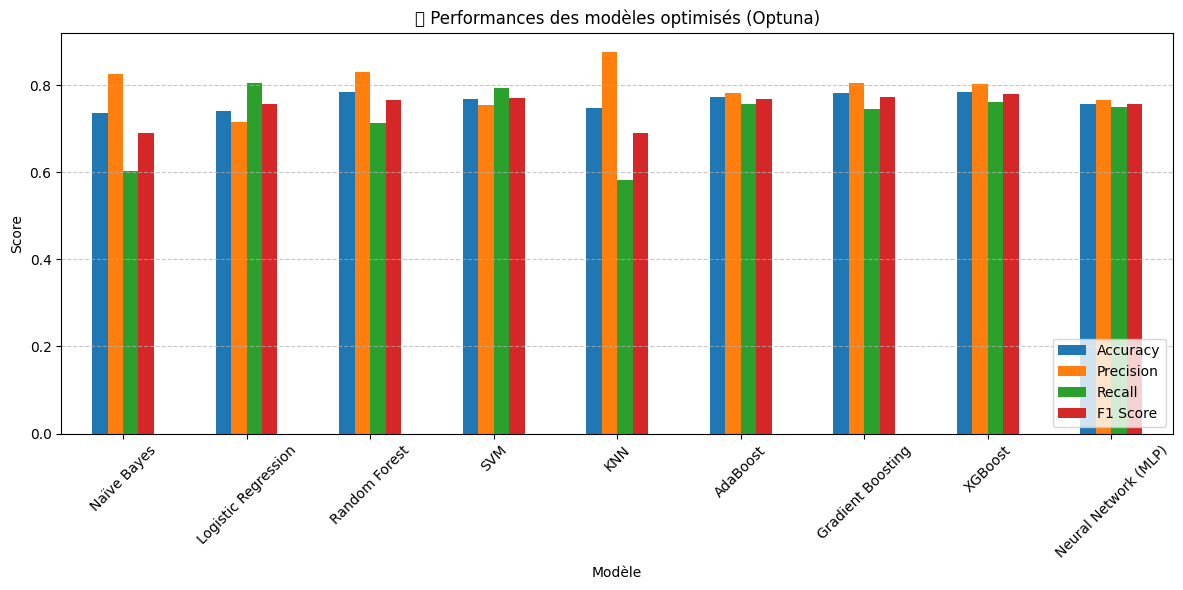

In [160]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# 📦 Modèles
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

X = X_final_clean
y = y2
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 📊 Stockage final
final_scores = {}

# 📌 Dictionnaire de fonctions objectives
def get_objective(model_name):
    def objective(trial):
        if model_name == "Logistic Regression":
            model = LogisticRegression(
                C=trial.suggest_loguniform('C', 1e-3, 1),
                max_iter=500
            )
        elif model_name == "Random Forest":
            model = RandomForestClassifier(
                n_estimators=trial.suggest_int('n_estimators', 50, 200),
                max_depth=trial.suggest_int('max_depth', 2, 20),
                min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
                max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
            )
        elif model_name == "SVM":
            kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
            params = {
                "C": trial.suggest_loguniform('C', 1e-2, 1),
                "kernel": kernel,
                "gamma": trial.suggest_categorical('gamma', ['scale', 'auto'])
            }
            if kernel == "poly":
                params["degree"] = trial.suggest_int("degree", 2, 5)
            model = SVC(**params)
        elif model_name == "KNN":
            model = KNeighborsClassifier(
                n_neighbors=trial.suggest_int('n_neighbors', 3, 15),
                weights=trial.suggest_categorical('weights', ['uniform', 'distance'])
            )
        elif model_name == "AdaBoost":
            model = AdaBoostClassifier(
                n_estimators=trial.suggest_int('n_estimators', 50, 200),
                learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0),
            )
        elif model_name == "Gradient Boosting":
            model = GradientBoostingClassifier(
                n_estimators=trial.suggest_int('n_estimators', 50, 200),
                learning_rate=trial.suggest_float('learning_rate', 0.01, 1.0),
                max_depth=trial.suggest_int('max_depth', 2, 10),
                subsample=trial.suggest_float("subsample", 0.5, 1.0),

            )
        elif model_name == "XGBoost":
            model = XGBClassifier(
                use_label_encoder=False,
                eval_metric='logloss',
                n_estimators=trial.suggest_int('n_estimators', 50, 200),
                learning_rate=trial.suggest_float('learning_rate', 0.01, 0.5),
                max_depth=trial.suggest_int('max_depth', 3, 10),
                subsample=trial.suggest_float("subsample", 0.5, 1.0),
                colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0)

            )
        elif model_name == "Neural Network (MLP)":
            model = MLPClassifier(
                hidden_layer_sizes=(trial.suggest_int('hidden_layer_sizes', 50, 200),),
                learning_rate_init=trial.suggest_float('learning_rate_init', 0.0001, 0.1),
                max_iter=300,
                activation=trial.suggest_categorical("activation", ["relu", "tanh"]),
                alpha=trial.suggest_float("alpha", 1e-5, 1e-1)
            )


        elif model_name == "Naïve Bayes":
            model = MultinomialNB(
                alpha=trial.suggest_float('alpha', 1e-3, 1.0)
            )
        else:
            raise ValueError("Modèle non reconnu")
        
        accs = []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accs.append(accuracy_score(y_test, y_pred))
        return np.mean(accs)
    
    return objective

# ✅ Liste des modèles à tester
model_names = [
    "Naïve Bayes", "Logistic Regression", "Random Forest", "SVM",
    "KNN", "AdaBoost", "Gradient Boosting", "XGBoost", "Neural Network (MLP)"
]

# 🔁 Optimisation pour chaque modèle
for name in model_names:
    print(f"🔍 Optimisation de {name}...")
    study = optuna.create_study(direction='maximize')
    study.optimize(get_objective(name), n_trials=250)
    
    # ✅ Meilleurs hyperparams -> évaluation complète
    best_params = study.best_params
    if name == "Logistic Regression":
        model = LogisticRegression(**best_params, max_iter=500)
    elif name == "Random Forest":
        model = RandomForestClassifier(**best_params)
    elif name == "SVM":
        model = SVC(**best_params)
    elif name == "KNN":
        model = KNeighborsClassifier(**best_params)
    elif name == "AdaBoost":
        model = AdaBoostClassifier(**best_params)
    elif name == "Gradient Boosting":
        model = GradientBoostingClassifier(**best_params)
    elif name == "XGBoost":
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', **best_params)
    elif name == "Neural Network (MLP)":
        model = MLPClassifier(**best_params, max_iter=300)
    elif name == "Naïve Bayes":
        model = MultinomialNB(**best_params)
    
    acc_list, prec_list, rec_list, f1_list = [], [], [], []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc_list.append(accuracy_score(y_test, y_pred))
        prec_list.append(precision_score(y_test, y_pred, zero_division=0))
        rec_list.append(recall_score(y_test, y_pred, zero_division=0))
        f1_list.append(f1_score(y_test, y_pred, zero_division=0))
    
    final_scores[name] = {
        "Accuracy": f"{np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}",
        "Precision": f"{np.mean(prec_list):.3f}",
        "Recall": f"{np.mean(rec_list):.3f}",
        "F1 Score": f"{np.mean(f1_list):.3f}",
    }

# ✅ Résumé des performances optimisées
df_final_scores = pd.DataFrame(final_scores).T
display(df_final_scores)

# 📊 Visualisation
plot_df = df_final_scores[["Accuracy", "Precision", "Recall", "F1 Score"]].copy()
plot_df["Accuracy"] = plot_df["Accuracy"].str.extract(r"([\d\.]+)").astype(float)
plot_df[["Precision", "Recall", "F1 Score"]] = plot_df[["Precision", "Recall", "F1 Score"]].astype(float)

plot_df.plot(kind='bar', figsize=(12, 6))
plt.title("📊 Performances des modèles optimisés (Optuna)")
plt.xlabel("Modèle")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
### 5 n_splits , 100 n_trials

# Accuracy	Precision	Recall	F1 Score
# Naïve Bayes	0.733 ± 0.024	0.756	0.800	0.687
# Logistic Regression	0.782 ± 0.027	0.780	0.824	0.752
# Random Forest	0.772 ± 0.023	0.806	0.840	0.743
# SVM	0.830 ± 0.050	0.804	0.880	0.757
# KNN	0.782 ± 0.041	0.960	0.745	0.653
# AdaBoost	0.772 ± 0.026	0.792	0.800	0.733
# Gradient Boosting	0.762 ± 0.026	0.795	0.765	0.730
# XGBoost	0.802 ± 0.041	0.792	0.824	0.722
# Neural Network (MLP)	0.770 ± 0.040	0.800	0.760	0.716

### 5 n_splits , 200 n_trials

# Naïve Bayes	0.733 ± 0.026	0.756	0.800	0.741
Logistic Regression	0.792 ± 0.044	0.776	0.900	0.796
Random Forest	0.810 ± 0.022	0.833	0.840	0.816
SVM	0.810 ± 0.037	0.765	0.940	0.832
KNN	0.782 ± 0.018	0.909	0.686	0.761
AdaBoost	0.772 ± 0.028	0.769	0.800	0.777
Gradient Boosting	0.780 ± 0.031	0.850	0.760	0.756
XGBoost	0.822 ± 0.050	0.811	0.843	0.827
Neural Network (MLP)	0.770 ± 0.039	0.825	0.820	0.781

# TESTER 250 n_trials avec X_final_clean







# 5 n_splits , 500 n_trials

Naïve Bayes	0.733 ± 0.024	0.756	0.800	0.741
Logistic Regression	0.792 ± 0.042	0.774	0.900	0.796
Random Forest	0.812 ± 0.031	0.808	0.860	0.816
SVM	0.812 ± 0.042	0.763	0.960	0.826
KNN	0.782 ± 0.018	0.909	0.686	0.761
AdaBoost	0.782 ± 0.030	0.796	0.780	0.780
Gradient Boosting	0.750 ± 0.034	0.755	0.740	0.747
XGBoost	0.832 ± 0.052	0.827	0.843	0.835
Neural Network (MLP)	0.762 ± 0.029	0.760	0.800	0.765


[I 2025-05-02 01:56:48,784] A new study created in memory with name: no-name-cee47c4d-bd05-48f5-b56d-41987b42c02d
[I 2025-05-02 01:56:49,599] Trial 0 finished with value: 0.5791549880618707 and parameters: {'kernel': 'sigmoid', 'C': 0.0067105451169824585, 'gamma': 'scale'}. Best is trial 0 with value: 0.5791549880618707.
[I 2025-05-02 01:56:50,373] Trial 1 finished with value: 0.5791549880618707 and parameters: {'kernel': 'linear', 'C': 0.006341042897242594, 'gamma': 'scale'}. Best is trial 0 with value: 0.5791549880618707.
[I 2025-05-02 01:56:51,173] Trial 2 finished with value: 0.5791549880618707 and parameters: {'kernel': 'sigmoid', 'C': 0.00245913517026566, 'gamma': 'scale'}. Best is trial 0 with value: 0.5791549880618707.
[I 2025-05-02 01:56:51,939] Trial 3 finished with value: 0.7574483546143465 and parameters: {'kernel': 'linear', 'C': 0.9784478347570393, 'gamma': 'auto'}. Best is trial 3 with value: 0.7574483546143465.
[I 2025-05-02 01:56:52,726] Trial 4 finished with value: 0.

🎯 Meilleurs hyperparamètres trouvés : {'kernel': 'linear', 'C': 0.51716418913484, 'gamma': 'scale'}


,Accuracy,Precision,Recall,F1 Score
SVM Optimisé,0.775 ± 0.062,0.780,0.774,0.773


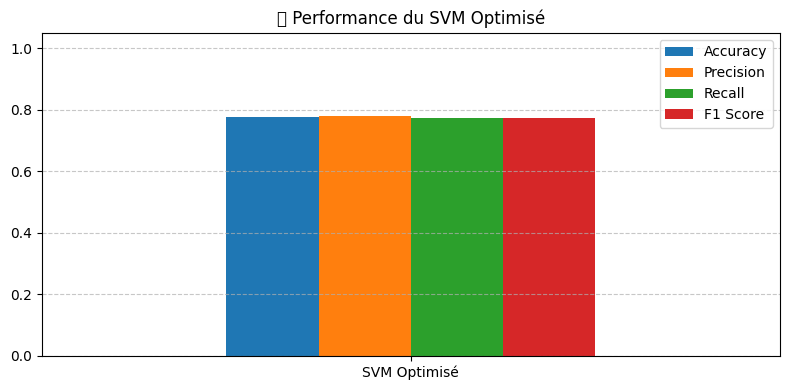

In [123]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

X = X_final_clean
# y = y2

skf = StratifiedKFold(n_splits=13, shuffle=True, random_state=42)

def objective(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"])
    params = {
        "C": trial.suggest_loguniform("C", 1e-3, 1),
        "kernel": kernel,
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"])
    }
    if kernel == "poly":
        params["degree"] = trial.suggest_int("degree", 2, 5)

    model = SVC(**params)

    accs = []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accs.append(accuracy_score(y_test, y_pred))

    return np.mean(accs)

# 🔍 Optimisation avec Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150, timeout=1000)  # Tu peux ajuster

# 📌 Meilleurs hyperparamètres
best_params = study.best_params
print("🎯 Meilleurs hyperparamètres trouvés :", best_params)

# ✅ Réévaluation complète avec meilleurs paramètres
final_model = SVC(**best_params)
acc_list, prec_list, rec_list, f1_list = [], [], [], []

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_test)

    acc_list.append(accuracy_score(y_test, y_pred))
    prec_list.append(precision_score(y_test, y_pred, zero_division=0))
    rec_list.append(recall_score(y_test, y_pred, zero_division=0))
    f1_list.append(f1_score(y_test, y_pred, zero_division=0))

# ✅ Résumé des scores
svm_scores = {
    "Accuracy": f"{np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}",
    "Precision": f"{np.mean(prec_list):.3f}",
    "Recall": f"{np.mean(rec_list):.3f}",
    "F1 Score": f"{np.mean(f1_list):.3f}"
}

df_svm = pd.DataFrame([svm_scores], index=["SVM Optimisé"])
display(df_svm)

# 📊 Graphe rapide
plot_df = df_svm.copy()
plot_df["Accuracy"] = plot_df["Accuracy"].str.extract(r"([\d\.]+)").astype(float)
plot_df[["Precision", "Recall", "F1 Score"]] = plot_df[["Precision", "Recall", "F1 Score"]].astype(float)

plot_df.plot(kind='bar', figsize=(8, 4))
plt.title("📊 Performance du SVM Optimisé")
plt.xticks(rotation=0)
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [105]:
#                              Accuracy	  Precision	Recall	F1 Score
# 3 splits : SVM Optimisé	0.808 ± 0.054	0.787	0.843	0.814
# 4 splits : SVM Optimisé	0.816 ± 0.048	0.810	0.823	0.816
# 5 splits : SVM Optimisé	0.830 ± 0.033	0.780	0.920	0.844 
# 5   mean : SVM Optimisé	0.767 ± 0.031	0.756	0.793	0.772
# 6 splits : SVM Optimisé	0.843 ± 0.050	0.821	0.905	0.854
# 7 splits : SVM Optimisé	0.831 ± 0.041	0.833	0.861	0.838
# 8 splits : SVM Optimisé	0.871 ± 0.059	0.848	0.903	0.875
# 9 splits : SVM Optimisé	0.875 ± 0.051	0.818	0.964	0.885
# 9   mean : SVM Optimisé	0.777 ± 0.044	0.772	0.793	0.779
# 10 Splits : SVM Optimisé	0.840 ± 0.057	0.774	0.960	0.857
# 11 splits : SVM Optimisé	0.889 ± 0.071	0.815	1.000	0.898
# 12 splits : SVM Optimisé	0.857 ± 0.056	0.867	0.905	0.864
# 13 splits : SVM Optimisé	0.921 ± 0.092	0.864	1.000	0.927
# 13   mean : SVM Optimisé	0.775 ± 0.062	0.780	0.774	0.773
# 14 splits : SVM Optimisé	0.889 ± 0.058	0.889	0.889	0.889
# 15 splits : SVM Optimisé	0.909 ± 0.059	0.923	0.938	0.909
# 15   mean : SVM Optimisé	0.773 ± 0.062	0.774	0.778	0.773


In [ ]:
class ModelPipeline:
    def __init__(self, name="ModelPipeline"):
        self.name = name
        self.models = {
            "Naïve Bayes": MultinomialNB(),
            "Random Forest": RandomForestClassifier(n_jobs=-1),
            "SVM": SVC(kernel='linear'),
            "KNN": KNeighborsClassifier(n_jobs=-1),
            "AdaBoost": AdaBoostClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
            "Neural Network - MLP": MLPClassifier(max_iter=300)
        }
        self.scorers = {
            "Accuracy": make_scorer(accuracy_score),
            "Precision": make_scorer(precision_score, average='weighted'),
            "Recall": make_scorer(recall_score, average='weighted'),
            "F1 Score": make_scorer(f1_score, average='weighted')
        }
        self.results = {}

    def preprocess_data(self, df, with_preprocessing=False):
        """Preprocess data based on the phase (with or without preprocessing)"""
        # Convert emojis
        df['text'] = df['text'].apply(lambda x: emoji.demojize(x))
        
        # Add binary features
        df['has_url'] = df['text'].str.contains(r'http[s]?://', regex=True)
        df['has_mention'] = df['text'].str.contains(r'@\w+', regex=True)
        df['has_hashtag'] = df['text'].str.contains(r'#\w+', regex=True)
        df['has_emoji'] = df['text'].str.contains(r':[^:\s]+:')
        
        if with_preprocessing:
            # Advanced preprocessing for Phase 2
            try:
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            except OSError:
                print("Installing spaCy models...")
                import os
                os.system("python -m spacy download fr_core_news_sm")
                os.system("python -m spacy download en_core_web_sm")
                nlp_fr = spacy.load("fr_core_news_sm")
                nlp_en = spacy.load("en_core_web_sm")
            
            def clean_and_lemmatize_multilang(text):
                text = text.lower()
                text = re.sub(r"http\S+", "URL", text)
                text = re.sub(r"@\w+", "MENTION", text)
                text = re.sub(r"#(\w+)", r"\1", text)
                text = re.sub(r"[^\w\s:]", "", text)
                try:
                    lang = detect(text)
                except:
                    lang = "en"
                doc = nlp_fr(text) if lang == "fr" else nlp_en(text)
                return " ".join([token.lemma_ for token in doc if not token.is_stop])
            
            df['text_clean'] = df['text'].apply(clean_and_lemmatize_multilang)
            text_column = 'text_clean'
        else:
            text_column = 'text'

        return df, text_column

    def prepare_features(self, df, text_column, stopwords=None, max_features=10000):
        """Prepare feature matrix from preprocessed data with feature limitation"""
        vectorizer = TfidfVectorizer(
            min_df=5,
            max_df=0.95,
            stop_words=stopwords,
            lowercase=True,
            ngram_range=(1, 2),
            max_features=max_features
        ) if stopwords else TfidfVectorizer(max_features=max_features)
        
        X_text = df[text_column]
        X_tfidf = vectorizer.fit_transform(X_text)
        
        # Binary features
        extra_features = df[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
        X_extra = scipy.sparse.csr_matrix(extra_features.values)
        
        # Combine features
        X_final = scipy.sparse.hstack([X_tfidf, X_extra])
        
        return X_final, vectorizer

    def train_and_evaluate(self, X, y, phase_name):
        """Train and evaluate models using k-fold cross-validation"""
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        results = []
        
        for name, model in self.models.items():
            print(f"\n🔍 Training model: {name}")
            
            # Store metrics for each fold
            fold_metrics = {
                "Accuracy": [],
                "Precision": [],
                "Recall": [],
                "F1": []
            }
            
            # Iterate through folds
            for fold, (train_idx, test_idx) in enumerate(cv.split(X.toarray() if scipy.sparse.issparse(X) else X, y), 1):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                
                # Calculate and store metrics for this fold
                fold_metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
                fold_metrics["Precision"].append(precision_score(y_test, y_pred, average='weighted'))
                fold_metrics["Recall"].append(recall_score(y_test, y_pred, average='weighted'))
                fold_metrics["F1"].append(f1_score(y_test, y_pred, average='weighted'))
                
                # Plot confusion matrix for last fold
                if fold == cv.n_splits:
                    plt.figure(figsize=(6, 5))
                    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
                    plt.title(f'Confusion Matrix - {name} ({phase_name})')
                    plt.xlabel('Predicted')
                    plt.ylabel('True')
                    plt.show()
            
            # Calculate mean and std of metrics across folds
            metrics = {
                "Model": name,
                "Phase": phase_name
            }
            
            for metric_name, scores in fold_metrics.items():
                metrics[metric_name] = np.mean(scores)
                metrics[f"{metric_name}_Std"] = np.std(scores)
                print(f"{metric_name}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")
            
            results.append(metrics)
        
        # Save results to CSV
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'model_results_{phase_name.lower().replace(" ", "_")}.csv', index=False)
        return results_df


In [ ]:
# Load data
print("Loading data...")
df = pd.read_csv('scitweets_balanced.tsv', sep='\t')
df.dropna(subset=['text'], inplace=True)
y = df['science_related']

# Display sample of the data
print("\nSample of the dataset:")
display(df.head())

# Initialize pipeline
pipeline = ModelPipeline()

In [ ]:
print("=== Phase 1: Without Preprocessing ===")
df_phase1, text_column = pipeline.preprocess_data(df.copy(), with_preprocessing=False)
X_phase1, _ = pipeline.prepare_features(df_phase1, text_column)
results_phase1 = pipeline.train_and_evaluate(X_phase1, y, "Without_Preprocessing")

# Display results
print("\nPhase 1 Results:")
display(results_phase1)


In [ ]:
print("=== Phase 2: With Preprocessing ===")
df_phase2, text_column = pipeline.preprocess_data(df.copy(), with_preprocessing=True)

# Load French stopwords
stopwords_df = pd.read_csv("StopWordsFrench.csv", sep=',', index_col=0)
french_stopwords = stopwords_df.index.tolist()

X_phase2, _ = pipeline.prepare_features(df_phase2, text_column, french_stopwords)
results_phase2 = pipeline.train_and_evaluate(X_phase2, y, "With_Preprocessing")

# Display results
print("\nPhase 2 Results:")
display(results_phase2)



In [ ]:
# Combine results
all_results = pd.concat([results_phase1, results_phase2])

# Plot comparison
plt.figure(figsize=(15, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']

for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 4, i)
    sns.barplot(data=all_results, x='Phase', y=metric, hue='Model')
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    if i > 1:  # Only show legend for the first subplot
        plt.legend([])
    
plt.tight_layout()
plt.show()

### import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# ✅ Définir la fonction objectif pour tuner MLP
def objective_mlp(trial):
    # Paramètres à optimiser
    hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", [(50,), (100,), (50, 50), (100, 50)])
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)  # Regularisation

    # Modèle MLP
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        max_iter=500,
        random_state=42,
        early_stopping=True  # Pour éviter l'overfitting
    )

    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédiction
    y_pred = model.predict(X_test)

    # Score d'accuracy
    return accuracy_score(y_test, y_pred)

# ✅ Créer une étude Optuna
study_mlp = optuna.create_study(direction="maximize")
study_mlp.optimize(objective_mlp, n_trials=50)  

# ✅ Résultats finaux
print("\n=== Résultats Optuna pour Neural Network (MLP) ===")
print("Meilleurs paramètres trouvés :", study_mlp.best_params)
print(f"Meilleure accuracy obtenue : {study_mlp.best_value:.4f}")
